<a href="https://colab.research.google.com/github/KaveeshaSamarathunga/Spam_emails_detection_using_Tensorflow/blob/main/spam_emails_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download("stopwords")

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv("spam_ham_dataset.csv")
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
data.shape

(5171, 4)

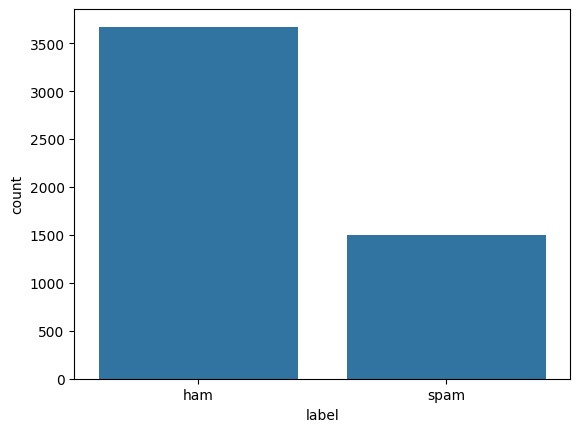

In [4]:
sns.countplot(x='label', data=data)
plt.show()

<Axes: xlabel='label', ylabel='count'>

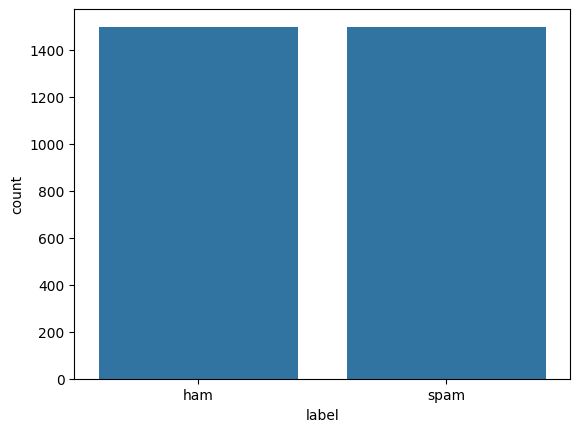

In [9]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

sns.countplot(x='label', data=balanced_data)

### Clean the text

In [10]:
# Remove "subjet:" text from mail body
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [11]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [12]:
# function to remove stopwords
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  imp_words = []

  for word in str(text).split():
    word = word.lower()

    if word not in stop_words:
      imp_words.append(word)

  output = " ".join(imp_words)

  return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


### Tokenization and Padding

In [20]:
train_X, test_X, train_y, test_y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
    )

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_seq = tokenizer.texts_to_sequences(train_X)
test_seq = tokenizer.texts_to_sequences(test_X)

# Define maximum length
max_len = 100
train_seq = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
test_seq = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

train_y = (train_y == 'spam').astype(int)
test_y = (test_y == 'spam').astype(int)

### Creating the model

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_seq, train_y,
    validation_data=(test_seq, test_y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4908 - loss: 0.2006 - val_accuracy: 0.5250 - val_loss: 0.1670 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5651 - loss: 0.1555 - val_accuracy: 0.6267 - val_loss: 0.1590 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6632 - loss: 0.1515 - val_accuracy: 0.6350 - val_loss: 0.1574 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6563 - loss: 0.1478 - val_accuracy: 0.6383 - val_loss: 0.1566 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6789 - loss: 0.1481 - val_accuracy: 0.9433 - val_loss: 0.1211 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9337 - loss: 0.1152 - val_accuracy: 0.9217 - val_loss: 0.1192 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9098 - loss: 0.1159 - val_acc

In [30]:
model.evaluate(test_seq, test_y)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9469 - loss: 0.1207


[0.12106510251760483, 0.9433333277702332]

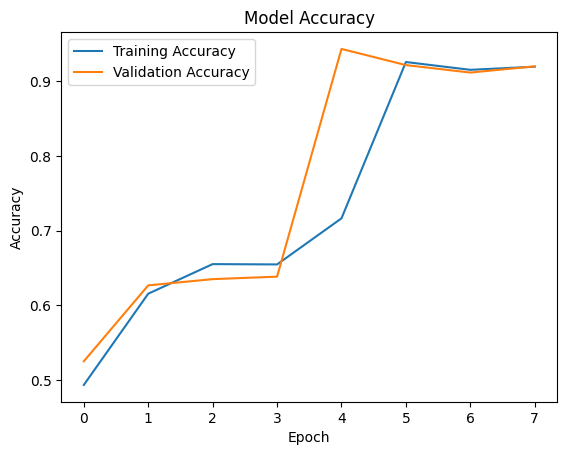

In [31]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()